In [6]:
import pandas as pd
import torch
from tqdm import tqdm
import torch.nn as nn
import matplotlib as plt
from torch.utils.data import Dataset
from torch.utils.data import random_split
from transformers import BertTokenizer, BertForSequenceClassification

In [2]:
df = pd.read_csv('data/AI_Human.csv')
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [3]:
# Assuming df is your original dataframe
df_zero = df[df['generated'] == 0]
df_one = df[df['generated'] == 1]

# Sample 5000 rows from each dataframe
df_zero_sampled = df_zero.sample(5000, random_state=1)
df_one_sampled = df_one.sample(5000, random_state=1)

# Concatenate the two dataframes
df = pd.concat([df_zero_sampled, df_one_sampled])
df.reset_index(inplace=True)

In [4]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, pad_index):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.generated
        self.max_len = max_len
        self.pad_index = pad_index

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        # Calculate the length of the sequence before padding
        text_length = len([token for token in ids if token != self.pad_index])

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'text_lengths': torch.tensor(text_length, dtype=torch.long)
        }

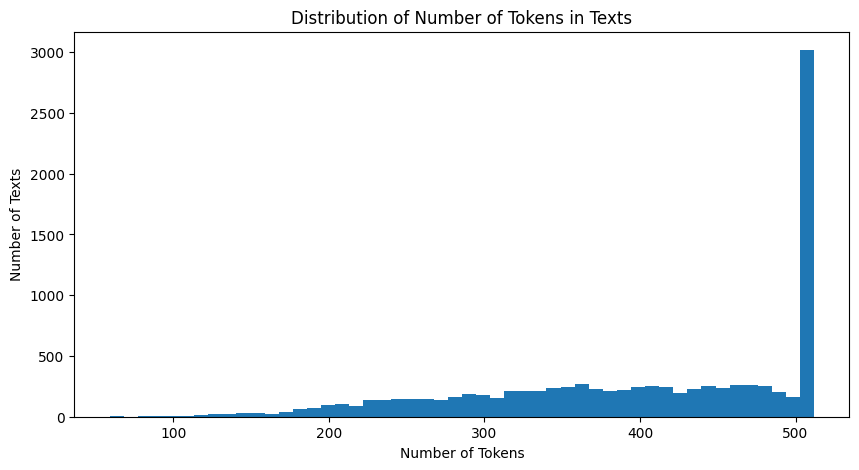

Maximum number of tokens in a text: 512
95th percentile of number of tokens in a text: 512.0
99th percentile of number of tokens in a text: 512.0


In [5]:
# Initializing the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing the text and calculating the number of tokens in each text
df['num_tokens'] = df['text'].apply(lambda x: len(tokenizer.encode(x, truncation=True)))

plt.figure(figsize=(10, 5))
plt.hist(df['num_tokens'], bins=50)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Texts')
plt.title('Distribution of Number of Tokens in Texts')
plt.show()

print(f"Maximum number of tokens in a text: {df['num_tokens'].max()}")
print(f"95th percentile of number of tokens in a text: {df['num_tokens'].quantile(0.95)}")
print(f"99th percentile of number of tokens in a text: {df['num_tokens'].quantile(0.99)}")

In [6]:
max_len = 512
pad_index = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

# Create the Dataset
dataset = TextDataset(df, tokenizer, max_len, pad_index)

In [7]:
def create_data_loaders(dataset, train_prop=0.8, val_prop=0.1, test_prop=0.1, batch_size=128):
    train_len = int(train_prop * len(dataset))
    val_len = int(val_prop * len(dataset))
    test_len = int(test_prop * len(dataset))

    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [8]:
train_loader, val_loader, test_loader = create_data_loaders(dataset)

In [9]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = 'bert-base-uncased'
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [22]:
# Create the model
model = BERT()

Vocab size: 30522


In [23]:
# Check if CUDA is available and set device to GPU if it is, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [24]:
# Defining loss function
criterion = nn.BCELoss()

# Defining the optimizer
optimizer = torch.optim.Adam(model.parameters())

# Moving the model and loss function to same device
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# Number of training epochs
epochs = 10

# Start the training loop
for epoch in range(epochs):
    model.train()
    # Create a progress bar for training
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch')

    for batch in train_progress_bar:
        # Zero the gradients
        optimizer.zero_grad()

        # Sort the sequences by length in descending order
        text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
        ids = batch['ids'][sorted_idx]
        targets = batch['targets'][sorted_idx]

        ids = ids.to(device)
        text_lengths = text_lengths.to(device)
        targets = targets.to(device)

        # Forward pass
        predictions = model(ids, targets)
        loss = criterion(predictions, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the training progress bar
        train_progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

    # Validation loop
    model.eval()
    with torch.no_grad():
        total_loss, total_correct, total_labels = 0, 0, 0
        for batch in val_loader:
            text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
            ids = batch['ids'][sorted_idx]
            targets = batch['targets'][sorted_idx]

            ids = ids.to(device)
            text_lengths = text_lengths.to(device)
            targets = targets.to(device)

            predictions = model(ids, text_lengths)
            loss = criterion(predictions, targets)

            total_loss += loss.item() * ids.size(0)
            total_correct += (predictions.round() == targets).sum().item()
            total_labels += ids.size(0)

        avg_loss = total_loss / total_labels
        avg_acc = total_correct / total_labels

        print(f'Validation Loss: {avg_loss:.3f}, Validation Accuracy: {avg_acc:.3f}')

In [ ]:
# # Saving in Colab
# path = "/content/drive/My Drive/AI classification/model.pth"

# # Save the model
# torch.save(model.state_dict(), path)

In [11]:
# Loading saved model
path = 'model.pth'
model = BERT()
model.load_state_dict(torch.load(path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTMClassifier(
  (embedding): Embedding(30522, 100)
  (lstm): LSTM(100, 32, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
model.eval()
with torch.no_grad():
    total_loss, total_correct, total_labels = 0, 0, 0
    for batch in test_loader:
        text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
        ids = batch['ids'][sorted_idx]
        targets = batch['targets'][sorted_idx]

        ids = ids.to(device)
        text_lengths = text_lengths.to(device)
        targets = targets.to(device)

        predictions = model(ids, text_lengths)
        loss = criterion(predictions, targets)

        total_loss += loss.item() * ids.size(0)
        total_correct += (predictions.round() == targets).sum().item()
        total_labels += ids.size(0)

    avg_loss = total_loss / total_labels
    avg_acc = total_correct / total_labels

    print(f'Test Loss: {avg_loss:.3f}, Test Accuracy: {avg_acc:.3f}')